### Tire Degradation Model: This is the most important model. Its basic idea is to answer the question: "By how many seconds will a specific tire get slower for each additional lap it runs?" It predicts the performance drop-off due to wear.

### The idea is to find out how tires behave
#### 1. is it track specific?
#### 2. how many laps on avg every tire lasts 

In [20]:
import fastf1 as f1
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
session = f1.get_session(2022,1,'R')
session.load(laps=True)

req         WARNING 	DEFAULT CACHE ENABLED! (319.9 MB) C:\Users\lamaq\AppData\Local\Temp\fastf1
core           INFO 	Loading data for Bahrain Grand Prix - Race [v3.6.0]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core        WARNING 	Driver 16 completed the race distance 00:00.050000 before the recorded end of the session.
core           INFO 	Finished 

In [11]:
laps = session.laps
laps.keys()

Index(['Time', 'Driver', 'DriverNumber', 'LapTime', 'LapNumber', 'Stint',
       'PitOutTime', 'PitInTime', 'Sector1Time', 'Sector2Time', 'Sector3Time',
       'Sector1SessionTime', 'Sector2SessionTime', 'Sector3SessionTime',
       'SpeedI1', 'SpeedI2', 'SpeedFL', 'SpeedST', 'IsPersonalBest',
       'Compound', 'TyreLife', 'FreshTyre', 'Team', 'LapStartTime',
       'LapStartDate', 'TrackStatus', 'Position', 'Deleted', 'DeletedReason',
       'FastF1Generated', 'IsAccurate'],
      dtype='object')

In [12]:
laps = laps[['Driver','LapTime','Compound','Stint', 'TyreLife', 'FreshTyre',]]
laps

,Driver,LapTime,Compound,Stint,TyreLife,FreshTyre
0,VER,0 days 00:01:40.236000,SOFT,1.0,4.0,False
1,VER,0 days 00:01:37.880000,SOFT,1.0,5.0,False
2,VER,0 days 00:01:38.357000,SOFT,1.0,6.0,False
3,VER,0 days 00:01:38.566000,SOFT,1.0,7.0,False
4,VER,0 days 00:01:38.877000,SOFT,1.0,8.0,False
...,...,...,...,...,...,...
1120,BOT,0 days 00:01:36.599000,SOFT,4.0,10.0,False
1121,BOT,0 days 00:01:36.959000,SOFT,4.0,11.0,False
1122,BOT,0 days 00:01:37.217000,SOFT,4.0,12.0,False
1123,BOT,0 days 00:01:37.260000,SOFT,4.0,13.0,False


In [14]:
type(laps['LapTime'][0])

pandas._libs.tslibs.timedeltas.Timedelta

In [ ]:
def convert_laptime_to_seconds(laps):
    """
    Convert LapTime from time delta format to seconds
    
    Args:
        laps: DataFrame containing lap data with LapTime column
        
    Returns:
        DataFrame with LapTime_Seconds column added
    """
    print(f"Original LapTime format example: {laps['LapTime'].iloc[0]}")
    print(f"LapTime dtype: {laps['LapTime'].dtype}")
    
    # Convert LapTime from time delta to seconds
    # This makes it much easier to work with for analysis and modeling
    laps['LapTime_Seconds'] = laps['LapTime'].dt.total_seconds()
    
    print(f"\nConverted LapTime_Seconds dtype: {laps['LapTime_Seconds'].dtype}")
    print(f"LapTime_Seconds range: {laps['LapTime_Seconds'].min():.3f} - {laps['LapTime_Seconds'].max():.3f} seconds")
    
    return laps

In [15]:
laps['LapTime_Seconds'] = laps['LapTime'].dt.total_seconds()
laps

C:\Users\lamaq\AppData\Local\Temp\ipykernel_6664\1111721983.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  laps['LapTime_Seconds'] = laps['LapTime'].dt.total_seconds()


,Driver,LapTime,Compound,Stint,TyreLife,FreshTyre,LapTime_Seconds
0,VER,0 days 00:01:40.236000,SOFT,1.0,4.0,False,100.236
1,VER,0 days 00:01:37.880000,SOFT,1.0,5.0,False,97.880
2,VER,0 days 00:01:38.357000,SOFT,1.0,6.0,False,98.357
3,VER,0 days 00:01:38.566000,SOFT,1.0,7.0,False,98.566
4,VER,0 days 00:01:38.877000,SOFT,1.0,8.0,False,98.877
...,...,...,...,...,...,...,...
1120,BOT,0 days 00:01:36.599000,SOFT,4.0,10.0,False,96.599
1121,BOT,0 days 00:01:36.959000,SOFT,4.0,11.0,False,96.959
1122,BOT,0 days 00:01:37.217000,SOFT,4.0,12.0,False,97.217
1123,BOT,0 days 00:01:37.260000,SOFT,4.0,13.0,False,97.260


In [18]:
"""Select relevant columns for tire analysis"""
tire_laps = laps[['Driver', 'LapTime_Seconds', 'Compound', 'Stint', 'TyreLife', 'FreshTyre']]
print("\nSelected columns for tire analysis:")
tire_laps.head()


Selected columns for tire analysis:


,Driver,LapTime_Seconds,Compound,Stint,TyreLife,FreshTyre
0,VER,100.236,SOFT,1.0,4.0,False
1,VER,97.880,SOFT,1.0,5.0,False
2,VER,98.357,SOFT,1.0,6.0,False
3,VER,98.566,SOFT,1.0,7.0,False
4,VER,98.877,SOFT,1.0,8.0,False


In [19]:
"""Analyze lap times by tire compound"""
print("\n=== Tire Compound Performance Analysis ===")
    
    # Basic statistics by tire compound
print("\nAverage lap times by tire compound:")
compound_stats = laps.groupby('Compound')['LapTime_Seconds'].agg(['mean', 'std', 'min', 'max', 'count']).round(3)
print(compound_stats)
    
print("\nTire compound performance summary:")
for compound in laps['Compound'].unique():
    compound_data = laps[laps['Compound'] == compound]
    print(f"{compound}: {compound_data['LapTime_Seconds'].mean():.3f}s ± {compound_data['LapTime_Seconds'].std():.3f}s (n={len(compound_data)})")
    


=== Tire Compound Performance Analysis ===

Average lap times by tire compound:
             mean     std     min      max  count
Compound                                         
HARD      100.861   5.863  97.324  123.697    104
MEDIUM    101.733   6.941  96.347  133.896    345
SOFT      103.827  10.770  94.570  149.264    669

Tire compound performance summary:
SOFT: 103.827s ± 10.770s (n=675)
MEDIUM: 101.733s ± 6.941s (n=345)
HARD: 100.861s ± 5.863s (n=105)



=== Tire Degradation Analysis ===


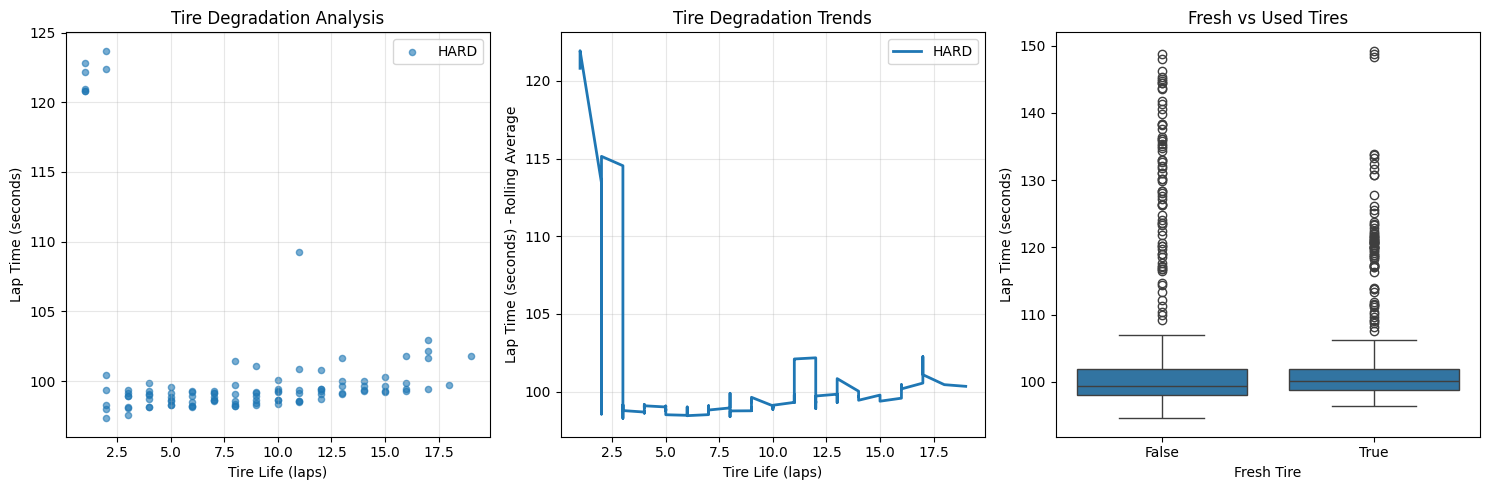

In [ ]:
"""Analyze tire degradation patterns"""
print("\n=== Tire Degradation Analysis ===")
    
plt.figure(figsize=(15, 5))
    
# Plot 1: All compounds together
plt.subplot(1, 3, 1)
for compound in laps['Compound'].unique():
    compound_data = laps[laps['Compound'] == compound]
plt.scatter(compound_data['TyreLife'], compound_data['LapTime_Seconds'], 
                   alpha=0.6, label=compound, s=20)
plt.xlabel('Tire Life (laps)')
plt.ylabel('Lap Time (seconds)')
plt.title('Tire Degradation Analysis')
plt.legend()
plt.grid(True, alpha=0.3)
    
    # Plot 2: By compound with rolling average
plt.subplot(1, 3, 2)
for compound in laps['Compound'].unique():
    compound_data = laps[laps['Compound'] == compound]
        # Calculate rolling average for smoother trend
    compound_data_sorted = compound_data.sort_values('TyreLife')
    rolling_avg = compound_data_sorted['LapTime_Seconds'].rolling(window=3, min_periods=1).mean()
plt.plot(compound_data_sorted['TyreLife'], rolling_avg, label=compound, linewidth=2)
plt.xlabel('Tire Life (laps)')
plt.ylabel('Lap Time (seconds) - Rolling Average')
plt.title('Tire Degradation Trends')
plt.legend()
plt.grid(True, alpha=0.3)
    
    # Plot 3: Fresh vs used tires
plt.subplot(1, 3, 3)
sns.boxplot(data=laps, x='FreshTyre', y='LapTime_Seconds')
plt.title('Fresh vs Used Tires')
plt.xlabel('Fresh Tire')
plt.ylabel('Lap Time (seconds)')
    
plt.tight_layout()
plt.show()

In [24]:
laps['Compound'].unique()

array(['SOFT', 'MEDIUM', 'HARD'], dtype=object)

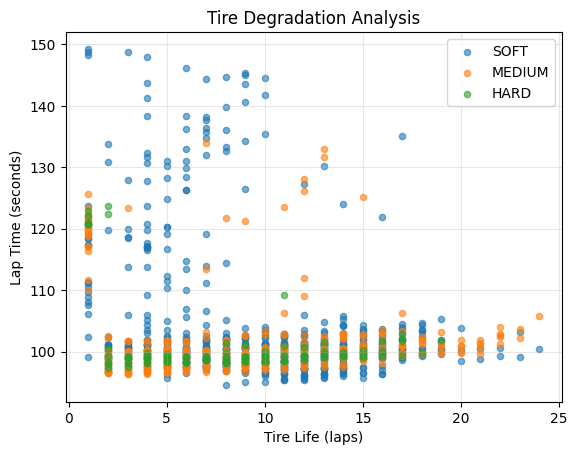

In [ ]:
for compound in laps['Compound'].unique():
    compound_data = laps[laps['Compound'] == compound]
    plt.scatter(compound_data['TyreLife'], compound_data['LapTime_Seconds'], 
                   alpha=0.6, label=compound, s=20)
plt.xlabel('Tire Life (laps)')
plt.ylabel('Lap Time (seconds)')
plt.title('Tire Degradation Analysis')
plt.legend()
plt.grid(True, alpha=0.3)

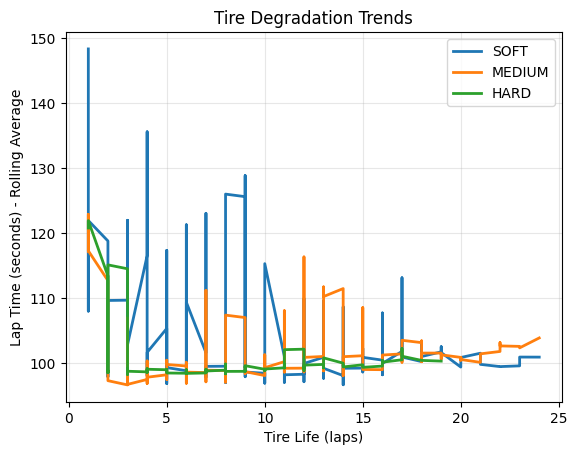

In [32]:
for i,compound in enumerate(laps['Compound'].unique()):
        compound_data = laps[laps['Compound'] == compound]
        # Calculate rolling average for smoother trend
        compound_data_sorted = compound_data.sort_values('TyreLife')
        rolling_avg = compound_data_sorted['LapTime_Seconds'].rolling(window=3, min_periods=1).mean()
        #plt.subplot(3,1,(i+1))
        plt.plot(compound_data_sorted['TyreLife'], rolling_avg, label=compound, linewidth=2)
plt.xlabel('Tire Life (laps)')
plt.ylabel('Lap Time (seconds) - Rolling Average')
plt.title('Tire Degradation Trends')
plt.legend()
plt.grid(True, alpha=0.3)

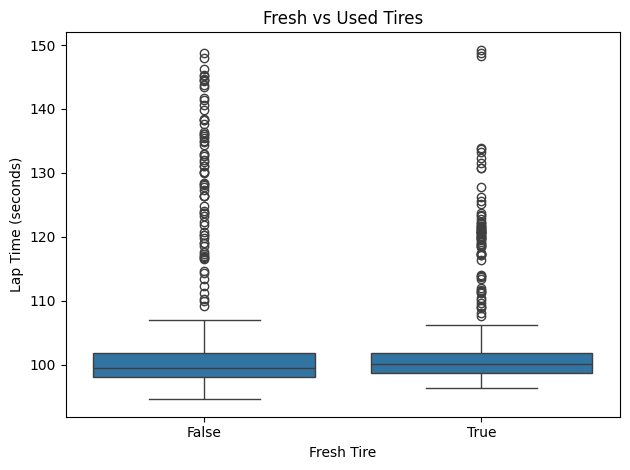

In [34]:

sns.boxplot(data=laps, x='FreshTyre', y='LapTime_Seconds')
plt.title('Fresh vs Used Tires')
plt.xlabel('Fresh Tire')
plt.ylabel('Lap Time (seconds)')    
plt.tight_layout()
plt.show()